Notebook for read and wrangle of counties data

# Prepare environment

In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd

In [3]:
import sys
sys.path.append("..//..")
import config

import warnings
warnings.filterwarnings('ignore')

# Data reading

In [4]:
# load legal amazon limits
am_bounds = gpd.read_file(config.AMAZON_FRONTIER_DATA)

In [5]:
# load frames idx detail
frames_idx = pd.read_csv(config.TR_FRAMES_IDX, index_col=0)

In [7]:
# load frames deforestation area history
deforestation = pd.read_csv(config.TR_DEFORESTATION, index_col=0)
deforestation["date"] = pd.to_datetime(deforestation["date"])

In [8]:
# counties data
counties = gpd.read_file(config.COUNTIES_DATA)

# filter counties thta intersects with amazon borders
counties = counties[counties.intersects(am_bounds["geometry"].item())].copy()

In [10]:
counties

,CD_MUN,NM_MUN,SIGLA_UF,AREA_KM2,populacao,densidade,geometry
0,1100015,Alta Floresta D'Oeste,RO,7067.127,22516.0,3.186,"POLYGON ((-62.00806 -12.13379, -62.00784 -12.2..."
1,1100023,Ariquemes,RO,4426.571,111148.0,25.109,"POLYGON ((-63.17933 -10.13924, -63.17746 -10.1..."
2,1100031,Cabixi,RO,1314.352,5067.0,3.855,"POLYGON ((-60.52408 -13.32137, -60.37162 -13.3..."
3,1100049,Cacoal,RO,3793.000,86416.0,22.783,"POLYGON ((-61.35502 -11.50452, -61.35524 -11.5..."
4,1100056,Cerejeiras,RO,2783.300,16088.0,5.780,"POLYGON ((-60.82135 -13.11910, -60.81773 -13.1..."
...,...,...,...,...,...,...,...
5485,5214838,Nova Crixás,GO,7308.681,13020.0,1.781,"POLYGON ((-50.52083 -14.64909, -50.52161 -14.6..."
5492,5215256,Novo Planalto,GO,1254.491,4592.0,3.660,"POLYGON ((-49.42668 -13.24021, -49.37201 -13.2..."
5513,5218003,Porangatu,GO,4825.287,45866.0,9.505,"POLYGON ((-48.95950 -13.34251, -48.95937 -13.3..."
5530,5219407,Santa Rita do Araguaia,GO,1357.197,9110.0,6.712,"POLYGON ((-53.20498 -17.33472, -53.20500 -17.3..."


<Axes: >

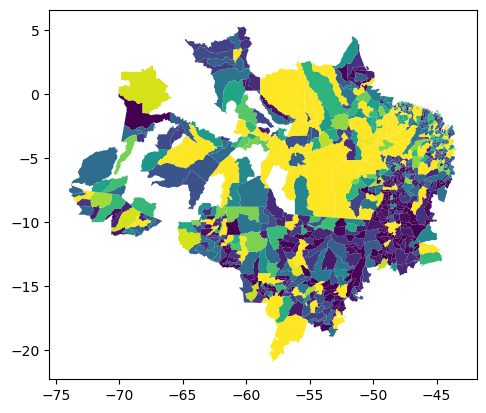

In [18]:
counties.plot(column="populacao", vmin=5e3, vmax=5e4)

## Merge county with frame and extract data

In [19]:
# load all frames
frames = gpd.read_file(config.TR_FRAMES)

In [20]:
frames.shape

(6999993, 5)

In [21]:
# get county for each frame
region = gpd.overlay(
    frames,
    counties[["CD_MUN", "SIGLA_UF", "populacao", "densidade", "geometry"]],
    how="intersection", 
    keep_geom_type=False
)
region["aprox_ar"] = region.geometry.area

# keep only biggest intersection by frame id
region = region.\
    sort_values("aprox_ar", ascending=False).\
    drop_duplicates(subset="frame_id", keep="first")\
    [["frame_id", "CD_MUN", "populacao", "densidade"]].\
    rename(columns={"CD_MUN": "county_id"}).\
    reset_index(drop=True)

In [11]:
# # get deforestation history for each county
# df = pd.merge(
#     region,
#     deforestation,
#     on="frame_id",
#     how="left",
#     validate="1:m"
# )
# county_defor = df.groupby(["county_id", "quarter_date"])["area"].sum().reset_index()

In [22]:
# save frames county data
region.to_csv(config.TR_COUNTIES)

# save counties deforestation history
# county_defor.to_csv(config.TR_COUNTIES_DEFOR)